# Import Models and Load Data

In [30]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import pandas as pd
pd.set_option("display.max_columns", 500)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, auc, roc_curve

In [31]:
from utils import cost_function, coster, get_scores

In [32]:
conn = sqlite3.connect("eia")
cursor = conn.cursor()
df = pd.DataFrame(cursor.execute("""select * from combined5""").fetchall())
df.columns = [description[0] for description in cursor.description]
df = df.drop(columns=["index", "level_0"])
df.head()

,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_county,coalmine_msha_id,coalmine_name,coalmine_state,coalmine_type,contract_expiration_date,contract_type,energy_source,fuel_cost,fuel_group,moisture_content,month,natural_gas_delivery_contract_type,natural_gas_supply_contract_type,natural_gas_transportation_service,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,year,plant_id_gen,combined_heat_and_power_plant,plant_name_gen,operator_name_gen,state_gen,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,aer_fuel_type_code,reserved_1,reserved_2,physical_unit_label,total_fuel_consumption_quantity,electric_fuel_consumption_quantity,total_fuel_consumption_mmbtu,elec_fuel_consumption_mmbtu,net_generation_megawatthours,year_gen,quantity_gen,elec_quantity_gen,mmbtu_per_unit_gen,tot_mmbtu_gen,elec_mmbtu_gen,netgen_gen,year_month_nerc,number_affected,disturbance_events
0,5.4,23.100,0.0,0.49,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,213.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,259412,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
1,5.7,22.800,0.0,0.48,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,211.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,52241,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
2,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CA,NG,NG,None,None,mcf,3433,3433,3559,3559,1609033,2008,2400,2400,1.04,2489,2489,146327,2008-1-SERC,0.0,0.0
3,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CT,NG,NG,None,None,mcf,30932077,30932077,32090118,32090118,2858195,2008,2781102,2781102,1.04,2884003,2884003,244784,2008-1-SERC,0.0,0.0
4,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,NG,NG,None,None,mcf,837652,837652,871270,871270,87265,2008,109281,109281,1.04,113543,113543,11487,2008-1-SERC,0.0,0.0


In [33]:
coal_fields = ["fuel_cost", "average_ash_content", "average_heat_content", "average_mercury_content", "average_sulfur_content", "chlorine_content", "coalmine_county","coalmine_state", "coalmine_type", "contract_type", "energy_source", "moisture_content",  "operator_id", "plant_id", "plant_state", "primary_transportation_mode", "purchase_type", "quantity", "reporting_frequency", "secondary_transportation_mode", "supplier", "combined_heat_and_power_plant", "nerc_region", "reported_prime_mover", "net_generation_megawatthours", "mmbtu_per_unit_gen", "disturbance_events", "number_affected"]

# Checking Correlations

In [94]:
# Label encode categorical fields so that they can be correlated
df_c = df[df["fuel_group"] == "Coal"][coal_fields]
not_encode = []
to_encode = []
for fld, fld_type in df_c[coal_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
le = LabelEncoder()
temp1 = df_c[not_encode].reset_index()
temp2 = df_c[to_encode].apply(le.fit_transform).reset_index()
df_c = temp1.merge(temp2, on="index").set_index("index")

In [95]:
corr = df_c.corr()

In [96]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:6]        
    for val in top_3.index:
        corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['disturbance_events', 'number_affected', 0.9253639677153023],
 ['number_affected', 'disturbance_events', 0.9253639677153023],
 ['coalmine_state', 'energy_source', 0.6261051500511815],
 ['energy_source', 'coalmine_state', 0.6261051500511815],
 ['fuel_cost', 'average_heat_content', 0.5707661703209599],
 ['average_heat_content', 'fuel_cost', 0.5707661703209599],
 ['average_heat_content', 'average_sulfur_content', 0.5374303332837997],
 ['average_sulfur_content', 'average_heat_content', 0.5374303332837997],
 ['average_ash_content', 'average_heat_content', 0.4359040238246023],
 ['average_heat_content', 'average_ash_content', 0.4359040238246023],
 ['average_heat_content', 'mmbtu_per_unit_gen', 0.4276605186448841],
 ['mmbtu_per_unit_gen', 'average_heat_content', 0.4276605186448841],
 ['average_sulfur_content', 'coalmine_type', 0.3873510421301765],
 ['coalmine_type', 'average_sulfur_content', 0.3873510421301765],
 ['average_ash_content', 'average_sulfur_content', 0.35814781332019957],
 ['aver

Some obvious correlations in here, like disturbance events and number affected (by disturbance events) similar for natural gas, or coalmine state and energy source, which is just coal type in this subset. It helps give an idea of the data, but it doesn't indicate any changes to features.

Heat content is interesting as it is possibly a major feature in determining fuel cost — potentially a direct gauge of fuel quality.

### Checking Correlations Involving Fuel Cost

In [97]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['fuel_cost', 'average_heat_content', 0.5707661703209599],
 ['fuel_cost', 'average_ash_content', 0.30212348809895695],
 ['fuel_cost', 'regulated', nan],
 ['average_heat_content', 'fuel_cost', 0.5707661703209599],
 ['average_ash_content', 'fuel_cost', 0.30212348809895695],
 ['fuel_cost', 'operator_id', 0.28714814295651925],
 ['operator_id', 'fuel_cost', 0.28714814295651925],
 ['fuel_cost', 'mmbtu_per_unit_gen', 0.23997196994779615],
 ['mmbtu_per_unit_gen', 'fuel_cost', 0.23997196994779615],
 ['fuel_cost', 'chlorine_content', 0.23149250910755437],
 ['chlorine_content', 'fuel_cost', 0.23149250910755437],
 ['fuel_cost', 'average_sulfur_content', 0.08942996342699425],
 ['average_sulfur_content', 'fuel_cost', 0.08942996342699425],
 ['fuel_cost', 'contract_type', 0.07305368428019887],
 ['contract_type', 'fuel_cost', 0.07305368428019887],
 ['fuel_cost', 'supplier', 0.05575496208195469],
 ['supplier', 'fuel_cost', 0.05575496208195469],
 ['fuel_cost', 'average_mercury_content', 0.05286164599131

Heat and ash content decently correlated with fuel cost makes sense as those can be direct factors of fuel quality for coal. Operator may be interesting to explore later.

Chlorine content is also interesting as it involves coal and environmental regulation.

# Modelling

In [37]:
def get_c():
    df_c = df[df["fuel_group"] == "Coal"][coal_fields]
    not_encode = []
    to_encode = []
    for fld, fld_type in df_c[coal_fields].dtypes.items():
        if "object" == fld_type:
            to_encode.append(fld)
        else:
            not_encode.append(fld)
    temp1 = df_c[not_encode].reset_index()
    temp2 = pd.get_dummies(df_c[to_encode]).reset_index()
    df_c = temp1.merge(temp2, on="index").set_index("index")
    return df_c


In [40]:
def get_xy():
    X = df_c.drop(columns=["fuel_cost"])
    # setting cutoff for a price spike at 97th percentile  = 2x 50th percentile
    y = (df_c.fuel_cost > df_c.fuel_cost.quantile(.8))
    return X, y

In [46]:
df_c = get_c()
X,y =get_xy()

## Train-Test Split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23)
results = model.fit(X_train, y_train)

In [10]:
results.score(X_test, y_test)

0.9833175837755325

Good accuracy

In [48]:
y_pred = results.predict(X_test)

In [49]:
get_scores(y_test, y_pred, X_test)

Precision: 0.8692774407060121
Recall: 0.8654585392641406
F1: 0.8673637864611997
       0     1
0  21340   711
1    735  4728
Cost Function: -0.09117711626541353


Good values on all scores. Lots of true positives.

## KFolds

In [69]:
scores = []
folds = KFold(n_splits=5, random_state=23)
for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = DecisionTreeClassifier(random_state=23, max_depth=10)
    y_pred = model.fit(X_train, y_train).predict(X_test)
    scores.append(get_scores(y_test, y_pred, X_test))

       0     1
0  16509  4782
1   2358  3865
Precision: 0.44697582976754946
Recall: 0.6210830789008517
F1: 0.5198386012104909
Cost Function: -0.08390287627304373
       0     1
0  21758  1708
1   1426  2622
Precision: 0.6055427251732102
Recall: 0.6477272727272727
F1: 0.6259250417760802
Cost Function: -0.07153902389330771
       0     1
0  22517  1669
1    976  2352
Precision: 0.5849291221089281
Recall: 0.7067307692307693
F1: 0.6400870866784597
Cost Function: -0.07000168611052884
       0     1
0  20122   967
1   2286  4138
Precision: 0.8105778648383938
Recall: 0.6441469489414695
F1: 0.7178419637436031
Cost Function: -0.11401696732325195
       0     1
0  19030  1016
1   3262  4205
Precision: 0.8054012641256464
Recall: 0.563144502477568
F1: 0.6628310214375788
Cost Function: -0.12953205621593777


In [70]:
np.mean([x["accuracy"] for x in scores])

0.8513464147332405

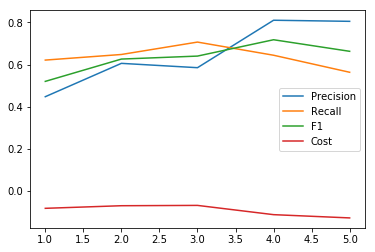

In [57]:
xs = list(range(1,6))
plt.plot(xs, [x["precision"] for x in scores], label="Precision")
plt.plot(xs, [x["recall"] for x in scores], label="Recall")
plt.plot(xs, [x["f1"] for x in scores], label="F1")
plt.plot(xs, [x["cost"] for x in scores], label="Cost")
plt.legend()

Good scores overall with little inconsistency. Cost-benefit is regularly above 7%

## ROC Curve

In [59]:
X,y = get_xy()

In [60]:
y_pred_proba = results.predict_proba(X_test)

In [61]:
y_pred_proba_1 = [x[1] for x in y_pred_proba]

In [62]:
pr = roc_curve(y_test, y_pred_proba_1)

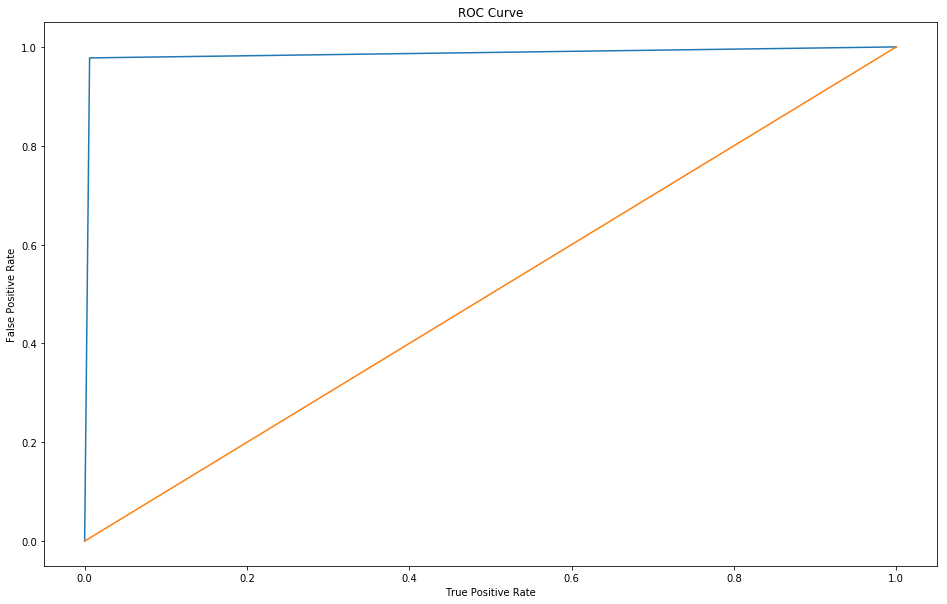

In [63]:
fig = plt.figure(figsize=(16,10))
plt.title("ROC Curve")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.plot(pr[0], pr[1])
plt.plot(pr[0],pr[0])

In [64]:
auc(pr[0], pr[1])

0.9858394862834632

Great ROC curve, AUC score.

## Cross-Validation

In [15]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.1562809099901088
Recall: 0.5738498789346247
F1: 0.24565949727908787
       0     1
0  24130  2559
1    352   474
Cost Function: -0.005507610692005371
       0     1
0  24130  2559
1    352   474
Precision: 0.5407925407925408
Recall: 0.5617433414043583
F1: 0.5510688836104513
       0    1
0  26294  394
1    362  464
Cost Function: -0.009363172550354038
       0    1
0  26294  394
1    362  464
Precision: 0.7928571428571428
Recall: 0.4036363636363636
F1: 0.5349397590361445
       0    1
0  26601   87
1    492  333
Cost Function: -0.013619196215828026
       0    1
0  26601   87
1    492  333
Precision: 0.48377862595419846
Recall: 0.6145454545454545
F1: 0.5413774693005873
       0    1
0  26147  541
1    318  507
Cost Function: -0.016222834197604567
       0    1
0  26147  541
1    318  507
Precision: 0.36910994764397903
Recall: 0.5127272727272727
F1: 0.4292237442922374
       0    1
0  25965  723
1    402  423
Cost Function: -0.016478957315423415
       0    1
0  25965  723


array([-0.00550761, -0.00936317, -0.0136192 , -0.01622283, -0.01647896])

In [18]:
np.mean([-0.00550761, -0.00936317, -0.0136192 , -0.01622283, -0.01647896])

-0.012238354

Most results show a negative value for the cost function. But the benefit is not that great compared to what natural gas was getting. Seeing if we can do better

## Features

In [65]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

average_heat_content 0.24269947984018175
average_sulfur_content 0.07889742461763186
primary_transportation_mode_RR 0.0674438778637404
net_generation_megawatthours 0.0654801754911223
quantity 0.04572021578662917
mmbtu_per_unit_gen 0.035824271533678315
average_ash_content 0.030009349333486736
nerc_region_RFC 0.016346171581014333
contract_type_S 0.014685046461589907
nerc_region_WECC 0.013434731876069465
coalmine_type_U 0.012376714110869325
moisture_content 0.011801201915297035
average_mercury_content 0.010665933440092114
operator_id_195.0 0.008508934264654815
nerc_region_FRCC 0.007310446788376852
contract_type_C 0.007255514953644726
operator_id_7801.0 0.007078301892936548
operator_id_18642.0 0.006303812512417558
purchase_type_S 0.006000503420692189
secondary_transportation_mode_RV 0.005722363913421393
coalmine_type_SU 0.005615012970059115
plant_id_2682 0.005336951904983158
coalmine_state_WV 0.005164788864943287
coalmine_type_P 0.004723907715730851
plant_state_KY 0.0045669836850985215
plan

coalmine_county_7.0 0.0
coalmine_county_71.0 0.0
coalmine_county_77 0.0
coalmine_county_78 0.0
coalmine_county_79 0.0
coalmine_county_87 0.0
coalmine_county_89 0.0
coalmine_county_9.0 0.0
coalmine_county_91 0.0
coalmine_county_93 0.0
coalmine_county_99.0 0.0
coalmine_county_IMP 0.0
coalmine_state_AK 0.0
coalmine_state_AZ 0.0
coalmine_state_ID 0.0
coalmine_state_IS 0.0
coalmine_state_KS 0.0
coalmine_state_LA 0.0
coalmine_state_MD 0.0
coalmine_state_MO 0.0
coalmine_state_N/A 0.0
coalmine_state_ND 0.0
coalmine_state_RS 0.0
coalmine_state_VZ 0.0
coalmine_state_WY 0.0
energy_source_LIG 0.0
energy_source_SC 0.0
energy_source_SUB 0.0
operator_id_10000.0 0.0
operator_id_11208.0 0.0
operator_id_11241.0 0.0
operator_id_11249.0 0.0
operator_id_11479.0 0.0
operator_id_11732.0 0.0
operator_id_12199.0 0.0
operator_id_12341.0 0.0
operator_id_12647.0 0.0
operator_id_12658.0 0.0
operator_id_12686.0 0.0
operator_id_12807.0 0.0
operator_id_1307.0 0.0
operator_id_13143.0 0.0
operator_id_13337.0 0.0
operat

supplier_INFINITY COAL 0.0
supplier_INGRAM BARGE 0.0
supplier_INR-WV 0.0
supplier_INTER AMERICAN COAL 0.0
supplier_INTER OCEAN 0.0
supplier_INTERCHEM 0.0
supplier_INTERNATIONAL CARBON RECOVERY 0.0
supplier_INTERNATIONAL RESOURCES 0.0
supplier_INTEROCEAN COAL 0.0
supplier_INTEROCEAN COAL SALES 0.0
supplier_INTERSTATE POWER & LIGHT 0.0
supplier_ION CARBON 0.0
supplier_ION CARBON B 0.0
supplier_ISAAC'S RUN 0.0
supplier_ISLAND SALES 0.0
supplier_Ikerd Coal Company LLC 0.0
supplier_JACOB RANCH 0.0
supplier_JAD COAL CO 0.0
supplier_JAMES OXFORD 0.0
supplier_JAMES RIVER COAL SALES INC. 0.0
supplier_JARVIS COAL LLC 0.0
supplier_JB MINERALS 0.0
supplier_JEFFERIES GROUP LLC 0.0
supplier_JERRY WHITE?S RECLAMATION SITE 0.0
supplier_JESSE CREEK MINING 0.0
supplier_JIM BRIDGER COAL 0.0
supplier_JM ADAMS 0.0
supplier_JONES FORK 0.0
supplier_KAJON 0.0
supplier_KCBX TERMINAL 0.0
supplier_KEMMERER 0.0
supplier_KEN AMERICAN 0.0
supplier_KENNECOTT COAL SALES 0.0
supplier_KENNECOTT ENERGY 0.0
supplier_KENT

In [43]:
X_test2 = X_test[X_test["chlorine_content"] >0]
y_test2 = y_test[X_test2.index]
y_pred = results.predict(X_test2)
get_scores(y_test2, y_pred, X_test2)

Precision: 0.8305084745762712
Recall: 0.7
F1: 0.7596899224806201
     0   1
0  294  10
1   21  49
Cost Function: -0.14297826494955465


In [44]:
X_test2 = X_test[X_test["chlorine_content"] <=0]
y_test2 = y_test[X_test2.index]
y_pred = results.predict(X_test2)
get_scores(y_test2, y_pred, X_test2)

Precision: 0.8742971159078542
Recall: 0.8664389717778177
F1: 0.8703503069700254
       0     1
0  20884   693
1    743  4820
Cost Function: -0.09726153490509111


# Trying Different Cutoffs

In [17]:
for cutoff in [.8, .85, .9, .95, .98]:
    X = df_c.drop(columns=["fuel_cost"])
    y = (df_c.fuel_cost > df_c.fuel_cost.quantile(cutoff))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    model = DecisionTreeClassifier(random_state=23)
    results = model.fit(X_train, y_train)
    get_scores(y_test, y_pred, X_test)
    

Precision: 0.19106699751861042
Recall: 0.028122717311906503
F1: 0.04902897166507482
       0    1
0  21386  652
1   5322  154
Cost Function: -0.09901782586560796
Precision: 0.13027295285359802
Recall: 0.025766871165644172
F1: 0.043023970497848806
       0    1
0  22738  701
1   3970  105
Cost Function: -0.07413086687793112
Precision: 0.10173697270471464
Recall: 0.02973168963016679
F1: 0.04601571268237935
       0    1
0  24032  724
1   2676   82
Cost Function: -0.04423698653286082
Precision: 0.05334987593052109
Recall: 0.03104693140794224
F1: 0.03925148334094021
       0    1
0  25366  763
1   1342   43
Cost Function: -0.020345804306306354
Precision: 0.019851116625310174
Recall: 0.029465930018416207
F1: 0.023721275018532245
       0    1
0  26181  790
1    527   16
Cost Function: -0.005965975151631981


Linear relationship between cutoff and score/cost. Not 

# Removing Features

In [98]:
df_c = get_c()

In [99]:
X = df_c.drop(columns=["fuel_cost"])
y = (df_c.fuel_cost > df_c.fuel_cost.quantile(.9))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [100]:
updated_fields = list(X.columns)
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    if b == 0:
        updated_fields.remove(a)

In [101]:
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train[updated_fields], y_train)

In [103]:
cost_function(y_test, y_pred, X[updated_fields].quantity.values)

       0     1
0  23102  1576
1   2650   186


-0.0002429775319730383

In [107]:
y_pred = results.predict(X_test[updated_fields])
get_scores(y_test, y_pred, X_test[updated_fields])

Precision: 0.7535460992907801
Recall: 0.2997179125528914
F1: 0.42885973763874874
       0    1
0  24400  278
1   1986  850
Cost Function: -0.014631024674093593


In [106]:
cross_val_score(results, X[updated_fields], y, scoring=coster, cv=5)

       0     1
0  22118  2645
1   1619  1133
       0    1
0  24379  384
1   1972  779
       0    1
0  24479  283
1   2139  612
       0     1
0  16543  8219
1   1632  1119
       0    1
0  24078  684
1   2226  525


array([-0.01069597, -0.00970215, -0.00897993,  0.01018614, -0.00819616])

Removing fields did not seem to help the model in this situation. 

# Analyze False Positives and Negatives

In [151]:
# Reload data label-encoded for correlation
# Label encode categorical fields so that they can be correlated
df_c = df[df["fuel_group"] == "Coal"][coal_fields]
not_encode = []
to_encode = []
for fld, fld_type in df_c[coal_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
le = LabelEncoder()
temp1 = df_c[not_encode].reset_index()
temp2 = df_c[to_encode].apply(le.fit_transform).reset_index()
df_c = temp1.merge(temp2, on="index").set_index("index")

In [152]:
y_pred = results.predict(X)

In [153]:
wrongs = (y_pred != y)

### Append the wrong flag on the dataframe so we can analyze and subset

In [154]:
df_c["wrong"] = wrongs

In [155]:
df_c = df_c[df_c["wrong"] == True].drop(columns="wrong")

### Correlations on the Dataset of Innaccurate Predictions

In [156]:
corr = df_c.corr()
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['fuel_cost', 'mmbtu_per_unit_gen', 0.09474135134932993],
 ['mmbtu_per_unit_gen', 'fuel_cost', 0.09474135134932993],
 ['fuel_cost', 'operator_id', 0.09183841572274025],
 ['operator_id', 'fuel_cost', 0.09183841572274025],
 ['fuel_cost', 'plant_id', 0.0780399094985484],
 ['plant_id', 'fuel_cost', 0.0780399094985484],
 ['fuel_cost', 'average_heat_content', 0.05826897535893543],
 ['average_heat_content', 'fuel_cost', 0.05826897535893543],
 ['fuel_cost', 'contract_type', 0.05365717704214404],
 ['contract_type', 'fuel_cost', 0.05365717704214404],
 ['fuel_cost', 'net_generation_megawatthours', 0.027302153723684743],
 ['net_generation_megawatthours', 'fuel_cost', 0.027302153723684743],
 ['fuel_cost', 'moisture_content', 0.02586111594842036],
 ['moisture_content', 'fuel_cost', 0.02586111594842036],
 ['fuel_cost', 'average_mercury_content', 0.0218392347788997],
 ['average_mercury_content', 'fuel_cost', 0.0218392347788997],
 ['fuel_cost', 'coalmine_county', 0.015959408711792564],
 ['coalmine_cou

Largest correlation of inaccurate predictions involves chlorine content. But looking at other top correlations too.

In [179]:
df_c["coalmine_state"].value_counts()

10    6971
28    4822
21    1039
4      938
26     918
1      877
6      762
3      606
7      490
23     222
25     204
18     175
12     122
14     120
11     100
24      93
29      83
0       69
20      38
27      37
13      25
15      17
5        1
8        1
17       1
16       1
Name: coalmine_state, dtype: int64

In [128]:
df_c["energy_source"].value_counts()

0    18728
1      139
3       55
4       12
2        1
Name: energy_source, dtype: int64

# Subsetting the Data - Where Chlorine Content > 0

In [19]:
df_c = get_c()
df_c2 = df_c[(df_c["chlorine_content"] >0)]

In [20]:
X = df_c2.drop(columns="fuel_cost")
y = (df_c2.fuel_cost > df_c.fuel_cost.quantile(.85))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [22]:
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [23]:
y_pred = results.predict(X_test)

In [24]:
get_scores(y_test, y_pred, X_test)

Precision: 0.625
Recall: 0.42857142857142855
F1: 0.5084745762711864
     0   1
0  331   9
1   20  15
Cost Function: -0.04467579991966315


In [25]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.6111111111111112
Recall: 0.39285714285714285
F1: 0.4782608695652174
     0   1
0  340   7
1   17  11
Cost Function: -0.0383053502341169
     0   1
0  340   7
1   17  11
Precision: 0.36363636363636365
Recall: 0.2857142857142857
F1: 0.32
     0   1
0  332  14
1   20   8
Cost Function: -0.024967928583513835
     0   1
0  332  14
1   20   8
Precision: 0.65
Recall: 0.4642857142857143
F1: 0.5416666666666667
     0   1
0  339   7
1   15  13
Cost Function: -0.058958747358350105
     0   1
0  339   7
1   15  13
Precision: 0.53125
Recall: 0.6071428571428571
F1: 0.5666666666666667
     0   1
0  331  15
1   11  17
Cost Function: -0.036944166682243616
     0   1
0  331  15
1   11  17
Precision: 0.7368421052631579
Recall: 0.5
F1: 0.5957446808510638
     0   1
0  341   5
1   14  14
Cost Function: -0.0639532908819803
     0   1
0  341   5
1   14  14


array([-0.03830535, -0.02496793, -0.05895875, -0.03694417, -0.06395329])

Scores are not great, but subset is small.

In [26]:
np.mean([-0.03830535, -0.02496793, -0.05895875, -0.03694417, -0.06395329])

-0.044625898

In [115]:
leaf1_test = y_test
leaf1_pred = y_pred

No abberations in cross_val_score

# Modeling Subset of Data - Chlorine Content <= 0

In [27]:
df_c = get_c()
df_c3 = df_c[(df_c["chlorine_content"] <=0)]

X = df_c3.drop(columns="fuel_cost")
y = (df_c3.fuel_cost > df_c.fuel_cost.quantile(.85))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier()
results = model.fit(X_train, y_train)

y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

Precision: 0.8218208445203807
Recall: 0.834448574969021
F1: 0.8280865715691096
       0     1
0  22375   730
1    668  3367
Cost Function: -0.06803644123567641


Much better F1 and cost on this subset

In [28]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.393726090283091
Recall: 0.6277140766040498
F1: 0.4839195034794057
       0     1
0  19079  3962
1   1526  2573
Cost Function: -0.04935921390937247
       0     1
0  19079  3962
1   1526  2573
Precision: 0.7709599027946537
Recall: 0.6191754086362528
F1: 0.6867812204031931
       0     1
0  22287   754
1   1561  2538
Cost Function: -0.06919524164314486
       0     1
0  22287   754
1   1561  2538
Precision: 0.6613394216133942
Recall: 0.6361639824304539
F1: 0.6485074626865672
       0     1
0  21706  1335
1   1491  2607
Cost Function: -0.08383584624556022
       0     1
0  21706  1335
1   1491  2607
Precision: 0.27590403337969405
Recall: 0.7745241581259151
F1: 0.40687091398538644
       0     1
0  14711  8330
1    924  3174
Cost Function: -0.040112838215392445
       0     1
0  14711  8330
1    924  3174
Precision: 0.5706040784917276
Recall: 0.723767691556857
F1: 0.6381239242685026
       0     1
0  20809  2232
1   1132  2966
Cost Function: -0.06487895161163855
       0     1

array([-0.04935921, -0.06919524, -0.08383585, -0.04011284, -0.06487895])

In [29]:
np.mean([-0.04935921, -0.06919524, -0.08383585, -0.04011284, -0.06487895])

-0.061476418

In [119]:
leaf2_pred = y_pred
leaf2_test = y_test

In [120]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

average_heat_content 0.1500884664715774
average_sulfur_content 0.08300733051560721
net_generation_megawatthours 0.07573769271186787
quantity 0.04769627070032838
primary_transportation_mode_RR 0.04091056261215417
average_ash_content 0.03998069559291624
mmbtu_per_unit_gen 0.03784399018180394
contract_type_S 0.021547106812363596
plant_state_GA 0.019569254786691484
average_mercury_content 0.01523307220307811
plant_id_628 0.012650757904671217
operator_id_7801.0 0.008860266782346027
plant_state_NC 0.008727774877683229
supplier_JP MORGAN VENTURES ENERGY 0.008586329776081094
purchase_type_S 0.008146437759934044
coalmine_type_P 0.008014401968573772
nerc_region_WECC 0.007145066584338601
supplier_ALPHA COAL 0.0065192659171169195
purchase_type_N/A 0.006511141269875775
operator_id_195.0 0.006414383438259733
nerc_region_RFC 0.006093551671097293
coalmine_type_U 0.006034331706464141
supplier_TRINITY COAL 0.005842025960873484
plant_id_26 0.005772075582580335
supplier_Massey 0.005739104515755842
coalmin

coalmine_county_51.0 0.0
coalmine_county_53 0.0
coalmine_county_55 0.0
coalmine_county_57 0.0
coalmine_county_57.0 0.0
coalmine_county_61.0 0.0
coalmine_county_63 0.0
coalmine_county_63.0 0.0
coalmine_county_65.0 0.0
coalmine_county_7.0 0.0
coalmine_county_71.0 0.0
coalmine_county_73 0.0
coalmine_county_77 0.0
coalmine_county_78 0.0
coalmine_county_87 0.0
coalmine_county_89 0.0
coalmine_county_9.0 0.0
coalmine_county_91 0.0
coalmine_county_97 0.0
coalmine_county_99.0 0.0
coalmine_state_AK 0.0
coalmine_state_AZ 0.0
coalmine_state_ID 0.0
coalmine_state_IS 0.0
coalmine_state_KS 0.0
coalmine_state_LA 0.0
coalmine_state_MO 0.0
coalmine_state_MT 0.0
coalmine_state_N/A 0.0
coalmine_state_ND 0.0
coalmine_state_NM 0.0
coalmine_state_OH 0.0
coalmine_state_OK 0.0
coalmine_state_OT 0.0
coalmine_state_RS 0.0
coalmine_state_VZ 0.0
energy_source_BIT 0.0
energy_source_LIG 0.0
energy_source_SC 0.0
energy_source_SUB 0.0
operator_id_10000.0 0.0
operator_id_11208.0 0.0
operator_id_11241.0 0.0
operator_id_

supplier_FOUNDATION COAL 0.0
supplier_FOUNDATION COAL WEST, INC 0.0
supplier_FOUNDATION COAL WEST, INCBELLE AYR 0.0
supplier_FRANCISCO 0.0
supplier_FREED MINE 0.0
supplier_FREELANDVILLE 0.0
supplier_FREEPOINT COMMODITIES LLC 0.0
supplier_FRIENDSVILLE 0.0
supplier_FUTURE INDUSTRIES INC 0.0
supplier_Falkirk Mine 0.0
supplier_First Energy 0.0
supplier_G & G MINES LLC. 0.0
supplier_G&S COAL 0.0
supplier_GALATIA 0.0
supplier_GALE SIZEMORE 0.0
supplier_GALLATIN 0.0
supplier_GATEWAY ENERGY & COKE COMPANY,LLC 0.0
supplier_GATLIFF COAL 0.0
supplier_GATLING, LLC 0.0
supplier_GBG SALES CORP, LLC 0.0
supplier_GENERAL WASTE SERVICES 0.0
supplier_GENESIS COAL 0.0
supplier_GENESIS CONSULTING 0.0
supplier_GENON ENERGY MANAGEMENT 0.0
supplier_GIBSON COUNTY 0.0
supplier_GIBSON COUNTY COAL, LLC 0.0
supplier_GLENCORE LTD 0.0
supplier_GLOBAL COALS GROUP, LLC 0.0
supplier_GLOBAL COMPANIES LLC 0.0
supplier_GLOBAL ENERGY 0.0
supplier_GOALS 0.0
supplier_GOFF 0.0
supplier_GOLDEN EAGLE INC. 0.0
supplier_GREG'S T